### TODO:

###### Build up fundamental model:
-Test speeds vs traditional methods  
-Energy distance test for distributions  
-Check distributions of variables within households, compare to naive method w/borysov model somehow  
-Test making epsilon the same distribution as the actual posteriors in the model

###### Differentiate from the GenSynth paper:
-Travel diaries  
-Method/heuristic/rules for checking large number of attributes  
-New models; Disentangled VAE/GAN  
-Model population changes over time RNN  
-Behavioral variables  

###### They suggest:
-Incorporate RNN to generate trip chains (time, location, mode, purpose)  
-Use GAN/other method to generate less inconsistencies  
-Address next stage of re-sampling to get future populations  

In [21]:
# Timestep is a trip
# Output of each timestep is departure time, duration, distance, mode, and purpose (dynamic)
# Input of each timestep is person/hh variables, day of week, and previous timestep info (static + dynamic)

# Each input to training the model is a person's daily trip diary
# Inputs; day of week, characteristics of person/hh
# Outputs; trip purpose, mode, duration, distance
# How to include Time of Day?
# Timesteps could either be hours in the day, or trips in a chain?
    # If a timestep is a trip, add the time of departure to the output variables
# Timestep is a trip
# Output of each timestep is departure time, duration, distance, mode, and purpose (y)
# Input of each timestep is person/hh variables, day of week, and previous timestep info (x)
# I should try embedding trips as a classification => one for each mode, orig/dest purpose

# Predict fewer than 1,000 characters as output for a given seed.
# Remove all punctuation from the source text, and therefore from the models’ vocabulary.
# Try a one hot encoded for the input sequences.
# Train the model on padded sentences rather than random sequences of characters.
# Increase the number of training epochs to 100 or many hundreds.
# Add dropout to the visible input layer and consider tuning the dropout percentage.
# Tune the batch size, try a batch size of 1 as a (very slow) baseline and larger sizes from there.
# Add more memory units to the layers and/or more layers.
# Experiment with scale factors (temperature) when interpreting the prediction probabilities.
# Change the LSTM layers to be “stateful” to maintain state across batches.


## Import Libraries and Datasets

In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing as skpre
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [2]:
# Load in the persons PUMS dataset for WA state
t_df = pd.read_csv('data/NHTS/nhts_survey/trippub.csv')
p_df = pd.read_csv('data/NHTS/nhts_survey/perpub.csv')
h_df = pd.read_csv('data/NHTS/nhts_survey/hhpub.csv')

## Choose Variables and Preprocess

In [3]:
# Filter to desired variables (numeric then categorical)
#TRIPPURP = simplified why/from
nhts_data_t = t_df[['TDCASEID','HOUSEID','PERSONID','TDAYDATE','TRAVDAY','TDTRPNUM','STRTTIME','TRVLCMIN','TRPMILES','TRPTRANS','WHYFROM','WHYTO']]
nhts_data_p = p_df[['HOUSEID','PERSONID','R_AGE','TIMETOWK','EDUC','R_SEX','OCCAT']]
nhts_data_h = h_df[['HOUSEID','HHSIZE','HHFAMINC','HHVEHCNT']]
del t_df
del p_df
del h_df
nhts_data = pd.merge(nhts_data_t, nhts_data_h, on='HOUSEID', how='left')
nhts_data = pd.merge(nhts_data, nhts_data_p, on=['HOUSEID', 'PERSONID'], how='left')

# Give each set of daily trips a unique chain id (each will be an input to model)
nhts_data['CHAINID'] = nhts_data.groupby(['TDAYDATE','HOUSEID','PERSONID']).ngroup().values
nhts_data = nhts_data.drop(labels=['TDAYDATE','TDCASEID','HOUSEID','PERSONID'], axis=1)

# Remove NA values and check n before/after
print(f"Dataset n={len(nhts_data)} pre-cleaning")
nan_indices = list((nhts_data < 0).any(axis=1))
nan_ids = nhts_data[nan_indices][['CHAINID']].values.flatten()
nhts_data = nhts_data[~(nhts_data['CHAINID'].isin(nan_ids))]
print(f"Dataset n={len(nhts_data)} post-cleaning")

Dataset n=923572 pre-cleaning
Dataset n=405590 post-cleaning


In [4]:
# Only dynamic variables
nhts_data = nhts_data[['CHAINID','TDTRPNUM','STRTTIME','TRVLCMIN','TRPMILES','TRAVDAY','TRPTRANS']].copy()
CAT_IDX = 4  # Number of categorical variables, not including chainid
MANIFEST_DIM = nhts_data.values.shape[1]-1 # All except chainid
VAR_NAMES = nhts_data.columns

In [5]:
# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
for x in range(CAT_IDX+1, MANIFEST_DIM+1):  # Include chainid because it is needed for now
    dummies = nhts_data.iloc[:,x]
    dummies = pd.get_dummies(dummies, prefix=f"{nhts_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]
print(f"Categorical variable class lengths: {CAT_LENGTHS}")

Categorical variable class lengths: [7, 21]


In [6]:
# Final data frame after encoding OHE
model_data_df = nhts_data.iloc[:,:CAT_IDX+1]
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)

# Preview data that will be fed into model
model_data_df

,CHAINID,TDTRPNUM,STRTTIME,TRVLCMIN,TRPMILES,TRAVDAY__1,TRAVDAY__2,TRAVDAY__3,TRAVDAY__4,TRAVDAY__5,...,TRPTRANS__12,TRPTRANS__13,TRPTRANS__14,TRPTRANS__15,TRPTRANS__16,TRPTRANS__17,TRPTRANS__18,TRPTRANS__19,TRPTRANS__20,TRPTRANS__97
2,46938,1,700,120,84.004,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,46938,2,1800,150,81.628,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,46940,1,1115,15,8.017,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,46940,2,2330,10,8.017,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,24626,1,550,15,3.395,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923567,93638,1,810,27,1.168,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
923568,93638,2,1320,8,0.238,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
923569,93638,3,1415,5,0.238,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
923570,93638,4,1820,25,0.867,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def standardizeRemoveOutliers(data_df, CAT_IDX):
    scaler = skpre.StandardScaler()
    data = data_df.values
    # Standardize the input data from -1 to 1 for numerical variables, remove outliers (x > 3 SD)
    data[:,1:CAT_IDX+1] = scaler.fit_transform(data[:,1:CAT_IDX+1])
    outlier_indices = np.where(np.any(data[:,1:CAT_IDX+1] > 3, axis=1))[0]
    outlier_chains = data_df.iloc[outlier_indices,:][['CHAINID']].values.flatten()
    data_df = data_df[~data_df['CHAINID'].isin(outlier_chains)]
    print(f"{len(outlier_chains)} outliers removed from data")
    return data_df, scaler

# Show how many chains are available before removing
print(f"{len(pd.unique(model_data_df['CHAINID']))} chains in dataset")

# Remove chains that have more than 5 trips in them
MAX_TIMESTEPS = 10  # Make sure to add 1 when generating the chain data (1 gets removed in training)
long_chains = model_data_df[model_data_df['TDTRPNUM'] > MAX_TIMESTEPS+1][['CHAINID']].values.flatten()
model_data_df = model_data_df[~model_data_df['CHAINID'].isin(long_chains)]
print(f"{len(long_chains)} chains longer than {MAX_TIMESTEPS} removed from data")

# Separate model data into train/test data
chain_ids = pd.unique(model_data_df['CHAINID'])
train_idx = round(len(chain_ids)*.9)
train_ids = chain_ids[0:train_idx]
test_ids = chain_ids[train_idx:len(chain_ids)]
train_data_df = model_data_df[model_data_df['CHAINID'].isin(train_ids)]
test_data_df = model_data_df[model_data_df['CHAINID'].isin(test_ids)]

# Remove outliers from datasets separately
train_data_df, scaler_train = standardizeRemoveOutliers(train_data_df, CAT_IDX)
test_data_df, scaler_test = standardizeRemoveOutliers(test_data_df, CAT_IDX)

95759 chains in dataset
3054 chains longer than 10 removed from data
8260 outliers removed from data
898 outliers removed from data


In [8]:
train_data_df

,CHAINID,TDTRPNUM,STRTTIME,TRVLCMIN,TRPMILES,TRAVDAY__1,TRAVDAY__2,TRAVDAY__3,TRAVDAY__4,TRAVDAY__5,...,TRPTRANS__12,TRPTRANS__13,TRPTRANS__14,TRPTRANS__15,TRPTRANS__16,TRPTRANS__17,TRPTRANS__18,TRPTRANS__19,TRPTRANS__20,TRPTRANS__97
6,46940,1,1115,15,8.017,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,46940,2,2330,10,8.017,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,24626,1,550,15,3.395,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,24626,2,700,15,3.395,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10,24626,3,730,10,1.059,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833046,183502,2,2045,15,3.136,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
833056,144272,1,1755,20,3.946,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
833062,205070,1,725,3,0.496,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
833063,205070,2,733,42,17.188,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
def pandasToTensor(data_df, scaler, CAT_IDX, MANIFEST_DIM, MAX_TIMESTEPS):
    samples_x = []
    samples_y = []
    chain_ids = pd.unique(data_df['CHAINID'])

    # This could be faster
    for chain_id in chain_ids:
        data = data_df[data_df['CHAINID'] == chain_id].values
        data[:,1:CAT_IDX+1] = scaler.transform(data[:,1:CAT_IDX+1])
        data = data.transpose()
        data = keras.preprocessing.sequence.pad_sequences(data, MAX_TIMESTEPS+1, padding='pre', dtype='float32').transpose()
        data = data[:,1:]  # Remove Chainid
        data_offset = data[1:,:]  # Validation data is offset by 1 timestep
        data = data[:-1,:]  # Remove the final timestep from input data (no validation for it)
        samples_x.append(data)
        samples_y.append(data_offset)

    # Dimensions are: (samples, timesteps, features)
    data_x = np.array(samples_x)
    data_y = np.array(samples_y)

    return data_x, data_y

# Convert the model data df into tensors with appropriate dimensions
train_data_x, train_data_y = pandasToTensor(train_data_df, scaler_train, CAT_IDX, MANIFEST_DIM, MAX_TIMESTEPS)
test_data_x, test_data_y = pandasToTensor(test_data_df, scaler_test, CAT_IDX, MANIFEST_DIM, MAX_TIMESTEPS)

# From here chainid has been removed and CAT_IDX doesn't need a +1

# shape = (#samples, timestep size, #features)
print(train_data_x.shape)
print(train_data_y.shape)
print(test_data_x.shape)
print(test_data_y.shape)

(78899, 10, 32)
(78899, 10, 32)
(8802, 10, 32)
(8802, 10, 32)


## Set Parameters and Define Model

In [10]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 100
LEARN_RATE = 0.001
RHO = 0.9
VAR_DIM = train_data_x.shape[2]

In [11]:
# LSTM layer requires inputs to be 3D tensor with shape [batch, timesteps, feature]
inputs = keras.Input(shape=(MAX_TIMESTEPS, VAR_DIM))
lstm = layers.LSTM(10, activation="tanh", return_sequences=True)(inputs)
outputs = layers.Dense(VAR_DIM, activation="tanh")(lstm)

# Define and print model
lstm_model = keras.Model(inputs, outputs)
lstm_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 32)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 10, 10)            1720      
_________________________________________________________________
dense (Dense)                (None, 10, 32)            352       
Total params: 2,072
Trainable params: 2,072
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Define custom loss function for combined numerical and categorical data
def get_loss(prediction, data_y, CAT_IDX, CAT_LENGTHS):

    # Mean squared error for numerical variables
    prediction_num = prediction[:,:,:CAT_IDX]
    data_y_num = data_y[:,:,:CAT_IDX]
    loss_num = keras.losses.mean_squared_error(data_y_num, prediction_num)
    loss_num = tf.reduce_mean(loss_num)
    
    # Categorical cross entropy for categorical variables
    loss_list = []
    current = CAT_IDX
    for i, x in enumerate(CAT_LENGTHS):
        prediction_cat = prediction[:,:,current:(current + x)]
        data_y_cat = data_y[:,:,current:(current + x)]
        loss = keras.losses.categorical_crossentropy(data_y_cat, prediction_cat, from_logits=True)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss)
        current += x
    loss_cat = tf.reduce_sum(loss_list)
    
    # Debugging
#     K.print_tensor(prediction_num, message="prediction_num:")
#     K.print_tensor(data_y_num, message="data_y_num:")
#     K.print_tensor(prediction_cat, message="prediction_cat:")
#     K.print_tensor(data_y_cat, message="data_y_cat:")
#     K.print_tensor(loss_num, message="loss_num:")
#     K.print_tensor(loss_cat, message="loss_cat:")

    # Return both losses; they are combined in the model
    return (loss_num, loss_cat)

In [13]:
# Loss metric recorder
loss_tracker = keras.metrics.Mean(name="loss")

# Custom training/loss for model
class RNN(keras.Model):
    def __init__(self, lstm_model, CAT_IDX, CAT_LENGTHS, **kwargs):
        super(RNN, self).__init__(**kwargs)
        self.lstm_model = lstm_model
        self.CAT_IDX = CAT_IDX
        self.CAT_LENGTHS = CAT_LENGTHS

    def train_step(self, data):
        # data is Tuple when x, y numpy arrays are passed
        if isinstance(data, tuple):
            data_x = data[0]
            data_y = data[1]

        with tf.GradientTape() as tape:
            # Predict sequence of data based on the passed sequence
            prediction = lstm_model(data_x)

            # Get loss between predicted sequence and actual
            loss_num, loss_cat = get_loss(
                prediction,
                data_y,
                self.CAT_IDX,
                self.CAT_LENGTHS
            )
            loss = tf.add(loss_num, loss_cat)

        # Get new gradients given the loss and take another step (update weights)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Record the loss metrics
        loss_tracker.update_state(loss)

        return {
            "loss": loss_tracker.result(),
            "loss_num": loss_num,
            "loss_cat": loss_cat,
        }

    def call(self, inputs):
        prediction = self.lstm_model(inputs)
        return prediction

    @property
    def metrics(self):
        return [loss_tracker]

## Training

In [14]:
# Save training checkpoints for the model
checkpoint_filepath = './model_checkpoints'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1)
callbacks_list = [model_checkpoint_callback]

# Delete files from previously run models
for filename in os.listdir(checkpoint_filepath):
    file_path = os.path.join(checkpoint_filepath, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

# Compile and train the model
rnn = RNN(lstm_model, CAT_IDX, CAT_LENGTHS)
rnn.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARN_RATE, rho=RHO, clipnorm=1.0))
history = rnn.fit(train_data_x, train_data_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list)

Epoch 1/100
1230/1233 [============================>.] - ETA: 0s - loss: 1.6969 - loss_num: 0.1479 - loss_cat: 1.5490
Epoch 00001: loss improved from inf to 1.69635, saving model to ./model_checkpoints
1233/1233 [==============================] - 9s 7ms/step - loss: 1.6964 - loss_num: 0.1478 - loss_cat: 1.5483
Epoch 2/100
1229/1233 [============================>.] - ETA: 0s - loss: 1.3965 - loss_num: 0.1215 - loss_cat: 1.2750
Epoch 00002: loss improved from 1.69635 to 1.39624, saving model to ./model_checkpoints
1233/1233 [==============================] - 9s 7ms/step - loss: 1.3962 - loss_num: 0.1215 - loss_cat: 1.2746
Epoch 3/100
1227/1233 [============================>.] - ETA: 0s - loss: 1.3479 - loss_num: 0.1147 - loss_cat: 1.2331
Epoch 00003: loss improved from 1.39624 to 1.34786, saving model to ./model_checkpoints
1233/1233 [==============================] - 9s 7ms/step - loss: 1.3479 - loss_num: 0.1147 - loss_cat: 1.2331
Epoch 4/100
1226/1233 [============================>.] -

Epoch 27/100
1228/1233 [============================>.] - ETA: 0s - loss: 1.1891 - loss_num: 0.1027 - loss_cat: 1.0864
Epoch 00027: loss improved from 1.18942 to 1.18928, saving model to ./model_checkpoints
1233/1233 [==============================] - 9s 7ms/step - loss: 1.1893 - loss_num: 0.1027 - loss_cat: 1.0867
Epoch 28/100
1230/1233 [============================>.] - ETA: 0s - loss: 1.1892 - loss_num: 0.1026 - loss_cat: 1.0866
Epoch 00028: loss improved from 1.18928 to 1.18914, saving model to ./model_checkpoints
1233/1233 [==============================] - 8s 7ms/step - loss: 1.1891 - loss_num: 0.1026 - loss_cat: 1.0866
Epoch 29/100
1229/1233 [============================>.] - ETA: 0s - loss: 1.1892 - loss_num: 0.1025 - loss_cat: 1.0866
Epoch 00029: loss improved from 1.18914 to 1.18903, saving model to ./model_checkpoints
1233/1233 [==============================] - 8s 7ms/step - loss: 1.1890 - loss_num: 0.1025 - loss_cat: 1.0865
Epoch 30/100
1233/1233 [=========================

1231/1233 [============================>.] - ETA: 0s - loss: 1.1876 - loss_num: 0.1015 - loss_cat: 1.0861
Epoch 00053: loss did not improve from 1.18760
1233/1233 [==============================] - 8s 7ms/step - loss: 1.1876 - loss_num: 0.1015 - loss_cat: 1.0861
Epoch 54/100
1227/1233 [============================>.] - ETA: 0s - loss: 1.1876 - loss_num: 0.1015 - loss_cat: 1.0861
Epoch 00054: loss improved from 1.18760 to 1.18758, saving model to ./model_checkpoints
1233/1233 [==============================] - 9s 7ms/step - loss: 1.1876 - loss_num: 0.1015 - loss_cat: 1.0861
Epoch 55/100
1226/1233 [============================>.] - ETA: 0s - loss: 1.1877 - loss_num: 0.1015 - loss_cat: 1.0862
Epoch 00055: loss did not improve from 1.18758
1233/1233 [==============================] - 9s 7ms/step - loss: 1.1876 - loss_num: 0.1015 - loss_cat: 1.0861
Epoch 56/100
1226/1233 [============================>.] - ETA: 0s - loss: 1.1876 - loss_num: 0.1015 - loss_cat: 1.0862
Epoch 00056: loss did not

Epoch 81/100
1227/1233 [============================>.] - ETA: 0s - loss: 1.1869 - loss_num: 0.1011 - loss_cat: 1.0857
Epoch 00081: loss improved from 1.18704 to 1.18701, saving model to ./model_checkpoints
1233/1233 [==============================] - 10s 8ms/step - loss: 1.1870 - loss_num: 0.1012 - loss_cat: 1.0858
Epoch 82/100
1233/1233 [==============================] - ETA: 0s - loss: 1.1870 - loss_num: 0.1012 - loss_cat: 1.0858
Epoch 00082: loss improved from 1.18701 to 1.18700, saving model to ./model_checkpoints
1233/1233 [==============================] - 9s 7ms/step - loss: 1.1870 - loss_num: 0.1012 - loss_cat: 1.0859
Epoch 83/100
1233/1233 [==============================] - ETA: 0s - loss: 1.1870 - loss_num: 0.1012 - loss_cat: 1.0858
Epoch 00083: loss improved from 1.18700 to 1.18700, saving model to ./model_checkpoints
1233/1233 [==============================] - 9s 8ms/step - loss: 1.1870 - loss_num: 0.1012 - loss_cat: 1.0859
Epoch 84/100
1231/1233 [========================

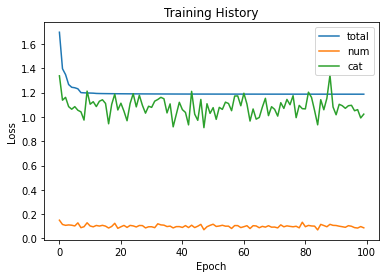

In [15]:
# Plot model loss/training progress
plt.plot(history.history['loss'])
plt.plot(history.history['loss_num'])
plt.plot(history.history['loss_cat'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","num","cat"], loc="upper right")
plt.show()

## Testing

In [16]:
# Create model and load the best set of weights saved in the checkpoint folder (to avoid running training every time)
checkpoint_filepath = './model_checkpoints'
rnn = RNN(lstm_model, CAT_IDX, CAT_LENGTHS)
rnn.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARN_RATE, rho=RHO, clipnorm=1.0))
rnn.load_weights(checkpoint_filepath).expect_partial()  # Keep an eye on this; only weights are loaded could cause issues

In [17]:
# Generate 10 trip chains, each with MAXTIMESTEPS timesteps (each represents 1 day for 1 individual)
NUM_CHAINS = 10
result_chains = []

for i in range(NUM_CHAINS):
    seed = np.random.rand(MAX_TIMESTEPS, VAR_DIM)
    #seed = np.zeros((MAX_TIMESTEPS, MANIFEST_DIM))  # Generate either random, or zero-based seed for first trip
    seed = np.reshape(seed, (1, MAX_TIMESTEPS, VAR_DIM))

    # Make first prediction to start from
    prediction = rnn.predict(seed, verbose=0)
    result = prediction

    # After each prediction, add the prediction to the results and re-predict the remaining timesteps from the results
    for j in range(1, MAX_TIMESTEPS):
        prediction = rnn.predict(result, verbose=0)
        result[:,j:,:] = prediction[:,j:,:]
    result_chains.append(result)

In [18]:
# Get the data in the same dimensions as the input data
synthetic_chains = np.array(result_chains).reshape(NUM_CHAINS, MAX_TIMESTEPS, VAR_DIM)

# Assign a trip chain id to each synthetic chain
chain_ids = []

# Get np array of chain ids to append, must be same dims as the synthetic results
for i in range(NUM_CHAINS):
    to_add = np.zeros(MAX_TIMESTEPS) + i
    to_add = np.reshape(to_add, (MAX_TIMESTEPS, 1))
    chain_ids.append(to_add)
chain_ids = np.array(chain_ids)
synthetic_chains = np.append(synthetic_chains, chain_ids, axis=2).reshape((NUM_CHAINS*MAX_TIMESTEPS), VAR_DIM+1)

# Use inverse scaler to reverse the normalization for numerical variables
synthetic_chains[:,:CAT_IDX] = scaler_train.inverse_transform(synthetic_chains[:,:CAT_IDX])

# Start the results df with the numerical vars
results_df = pd.DataFrame(synthetic_chains[:,:CAT_IDX])

# Use argmax to reverse the ohe encoding for categorical variables, add them to the results df
cat_results = []
current = CAT_IDX
for i, var_length in enumerate(CAT_LENGTHS):
    result = np.argmax(synthetic_chains[:,current:current+var_length], axis=1)+1
    results_df[f'cat_var_{i}'] = result
    current = current+var_length
    
# Add back chainids
results_df.insert(0, 'CHAINID', synthetic_chains[:,-1])

# Give the variables their manifest names back and display
results_df.columns = VAR_NAMES
results_df

,CHAINID,TDTRPNUM,STRTTIME,TRVLCMIN,TRPMILES,TRAVDAY,TRPTRANS
0,0.0,5.160619,1798.639318,45.150705,24.172357,7,5
1,0.0,1.118865,871.849414,42.638305,22.812644,1,3
2,0.0,1.114317,871.810574,42.860519,23.569889,1,3
3,0.0,1.115094,871.800514,42.904269,23.679031,1,3
4,0.0,2.385197,959.179314,46.562867,24.248460,1,1
...,...,...,...,...,...,...,...
95,9.0,1.217294,871.741890,42.723134,22.799733,1,3
96,9.0,1.263126,871.879537,43.257681,22.975043,1,3
97,9.0,1.218380,871.744489,42.738597,22.804565,1,3
98,9.0,1.218164,871.743958,42.735665,22.803621,1,3


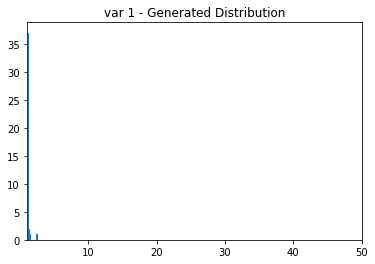

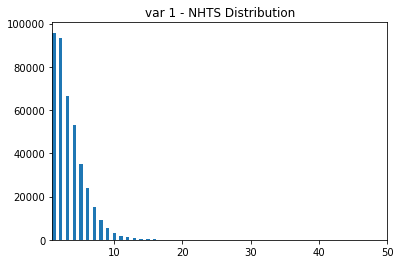

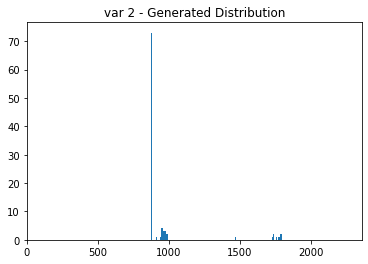

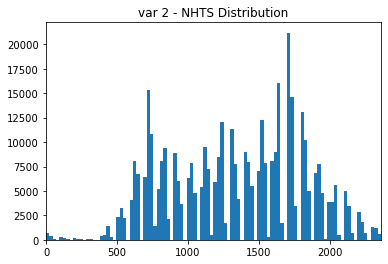

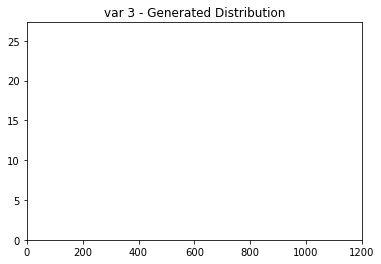

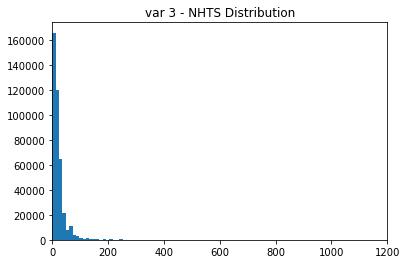

In [19]:
# Show distributions of the resulting numerical variables
for col_idx in range(1, CAT_IDX):
    results_data_plt = results_df.iloc[:,col_idx]
    nhts_data_plt = nhts_data.iloc[:,col_idx]

    plt.hist(results_data_plt, bins=100)
    plt.xlim(min(nhts_data_plt),max(nhts_data_plt))
    plt.title(f"var {col_idx} - Generated Distribution")
    plt.show()

    plt.hist(nhts_data_plt, bins=100)
    plt.xlim(min(nhts_data_plt),max(nhts_data_plt))
    plt.title(f"var {col_idx} - NHTS Distribution")
    plt.show()

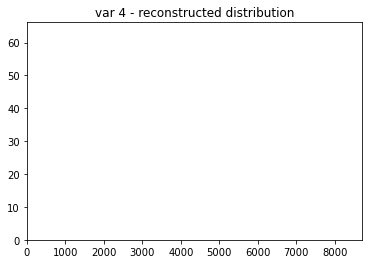

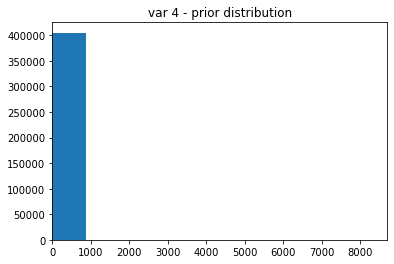

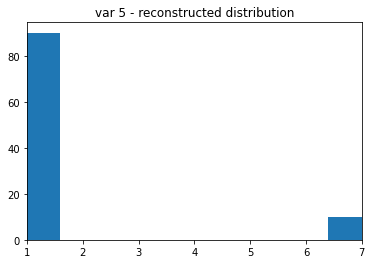

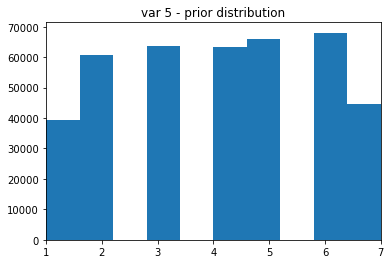

In [20]:
# Show distributions of the resulting categorical variables
for col_idx in range(CAT_IDX, MANIFEST_DIM):
    results_data_plt = results_df.iloc[:,col_idx]
    nhts_data_plt = nhts_data.iloc[:,col_idx]
    
    plt.hist(results_data_plt)
    plt.xlim(min(nhts_data_plt),max(nhts_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()
    
    plt.hist(nhts_data_plt)
    plt.xlim(min(nhts_data_plt),max(nhts_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()